In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import gc
import treecorr
import pyhalofit
import numpy as np
from wl.ximod import *
from wl import pltutil
import matplotlib.pylab as plt
import astropy.io.fits as pyfits

Dir1=  'mockana_ztrue1'
assert os.path.isdir(Dir1)

def convert_decosmo2halofitcosmo(decosmo, mnu=0.06):
    """Converts camb cosmology list to pyhalofit cosmology dict.
    """
    omnuh2 = 0.00064*(mnu/0.06)
    decosmo = decosmo.flatten()
    halofitcosmo = dict()
    halofitcosmo['Omega_de0'] = decosmo[2]
    halofitcosmo['w0'] = decosmo[5]
    halofitcosmo['h'] = ((omnuh2+decosmo[0]+decosmo[0])/(1.0-decosmo[2]))**0.5
    halofitcosmo['wa'] = 0
    halofitcosmo['Omega_K0'] = 0
    return halofitcosmo

# linear power
cparam = np.array([0.02254,0.11417,0.721,3.0836,0.97,-1.])

zmid=   np.array([0.0506,  0.1023,  0.1553,  0.2097, 0.2657,    0.3233,
    0.3827,  0.4442,  0.5078,  0.5739, 0.6425,  0.714,  0.7885, 0.8664,
    0.9479,  1.0334,  1.1233,  1.2179, 1.3176,  1.423 , 1.5345, 1.6528,
    1.7784,  1.9121,  2.0548,  2.2072, 2.3704,  2.5455, 2.7338, 2.9367,
    3.1559,  3.3932,  3.6507,  3.9309, 4.2367,  4.5712, 4.9382,
    5.3423],dtype=float)

In [2]:
nz  = 140
mnu = 0.0
linear_power = camb_class()
halofit = pyhalofit.halofit()
halofit.set_cosmology(convert_decosmo2halofitcosmo(cparam, mnu=mnu))
cosmo = halofit.cosmo
linear_power.set_cosmology(cparam, mnu=mnu, omk=0.0)
zl = np.logspace(-2.5, 0.76, nz)
#zl = np.concatenate([np.logspace(-6,-1.01, nz), np.linspace(1e-1, 6.0, nz)])
linear_power.init_pklin_array(zl)

Note: redshifts have been re-sorted (earliest first)


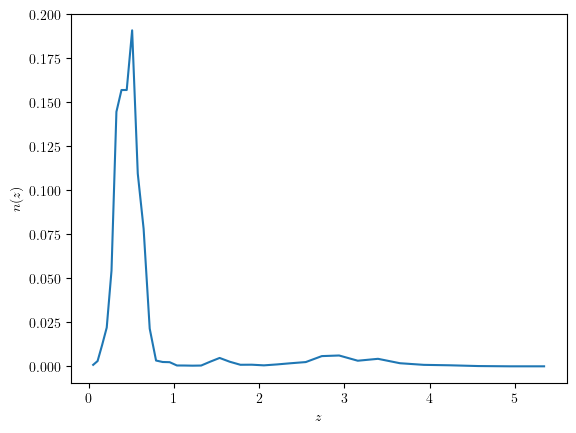

In [3]:
zdata=pyfits.getdata('../2_meas_nz_2pcf/nz_ture_ave.fits')
# let's test for the first redshift bin
pzs=zdata[0]
plt.plot(zmid,pzs)
plt.xlabel(r'$z$')
plt.ylabel(r'$n(z)$')
q_over_chi_func = efficiency_q_over_chi(zmid, pzs, cosmo)

In [18]:
l=np.loadtxt(os.path.join(Dir1,'shear_cl/ell.txt'))
cl = angular_power_spectrum(l, cosmo, linear_power,
     q_over_chi_func,q_over_chi_func, halofit)
xi_s = cl2xipm(l, cl, N_extrap_low=0)

Note: redshifts have been re-sorted (earliest first)
nu is required to be between (0.5-n) and 2.


90

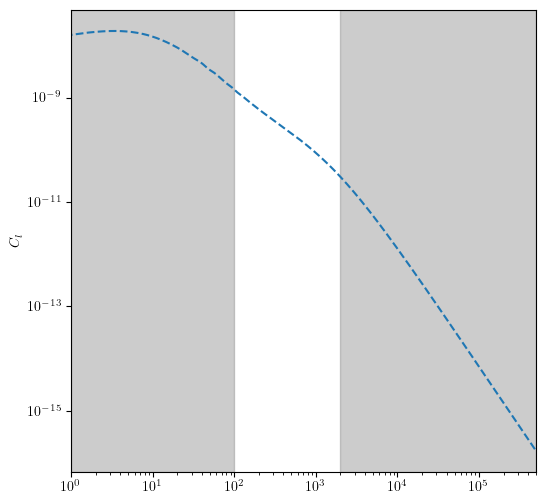

In [19]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.subplots(1,1)
ax1.plot(l,cl,'--',label='Model')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1,5e5)
ax1.set_ylabel(r'$C_l$')
ax1.axvspan(2e3, 5e5, alpha=0.4,color='gray')
ax1.axvspan(1, 100, alpha=0.4,color='gray')
# in COSMOSIS the default limit is from 0.1 to 5e5
gc.collect()
# average bias should be less than 0.005 at the scales of interest

# Xi

In [20]:
if False:
    corDir= '/hildafs/projects/phy200017p/andypark/skylens_lite/2pcf_800/'
    meanr = np.loadtxt(os.path.join(corDir,'r000_rot00/cf_0_0.txt'))[:, 0]
    ntheta= len(meanr)

    nsims = 2268# 2268
    xi_mock = np.zeros((nsims,2,ntheta))
    for i in range(nsims): 
        irot  = i%21
        irand = i//21
        cf_name = os.path.join(corDir,'r%03d_rot%02d/cf_0_0.txt' %(irand,irot))
        xi_mock[i,0]= np.loadtxt(cf_name)[:, 1]
        xi_mock[i,1]= np.loadtxt(cf_name)[:, 2]
    xi_mock=np.average(xi_mock, axis=0)
else: 
    xi_mock=pyfits.getdata('../2_meas_nz_2pcf/2pcf_ture_ave.fits')[0]
    cor =   treecorr.GGCorrelation(nbins=30,min_sep=0.25,max_sep=360.,sep_units='arcmin')
    meanr= cor.rnom

29673

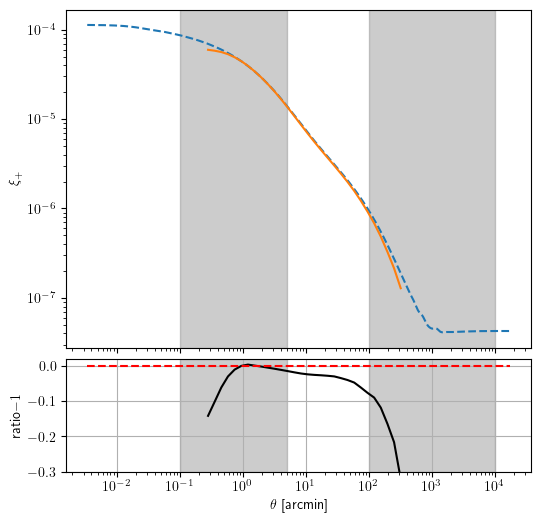

In [62]:
xi_sp=Interp1d(xi_s[0],xi_s[1])(meanr)
fig=plt.figure(figsize=(6,6))
axes=fig.subplots(2,1,gridspec_kw={'height_ratios':[3, 1],'hspace':0.05},sharex=True)
ax1=axes[0]
ax1.plot(xi_s[0],xi_s[1],'--',label='Model')
ax1.plot(meanr,xi_mock[0],'-',label='Mock')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel(r'$\xi_+$')

ax1.axvspan(1e2, 1e4, alpha=0.4,color='gray')
ax1.axvspan(1e-1, 5, alpha=0.4,color='gray')
plt.setp(ax1.get_xticklabels(), visible=False)

ax2=axes[1]
ax2.set_ylabel(r'ratio$-1$')
ax2.set_xlabel(r'$\theta$ [arcmin]')
ax2.set_xscale('log')
ax2.set_ylim(-0.3,0.02)
ax2.plot(meanr,xi_mock[0]/xi_sp-1,color='black')
ax2.plot(xi_s[0],np.zeros_like(xi_s[0]),'--',c='red')
ax2.axvspan(1e2, 1e4, alpha=0.4,color='gray')
ax2.axvspan(1e-1, 5, alpha=0.4,color='gray')
#ax2.set_yticks([-0.02,-0.01,0.,0.01,0.02])
ax2.grid()
# in COSMOSIS the default limit is from 0.1 to 5e5
gc.collect()
# bias is ~5% on average at scales 5 arcmin to 80 arcmin

In [135]:
iz = 0
zdata=pyfits.getdata('../2_meas_nz_2pcf/nz_ture_ave.fits')
# let's test for the first redshift bin
pzs=zdata[iz]
q_over_chi_func = efficiency_q_over_chi(zmid, pzs, cosmo, zl_bin=1000)
cl_corr = angular_power_spectrum_finite_shell(l, cosmo, linear_power, 
                         q_over_chi_func,q_over_chi_func, 
                         halofit)
# resolution effect
N_SIDE = 8192
l_sim = 1.6*N_SIDE
cl_corr = cl_corr/(1+(l/l_sim)**2)
sel = 3*N_SIDE < l
cl_corr[sel] = 0.0

xi_mock=pyfits.getdata('../2_meas_nz_2pcf/2pcf_ture_ave.fits')[iz]
cor =   treecorr.GGCorrelation(nbins=30,min_sep=0.25,max_sep=360.,sep_units='arcmin')
meanr= cor.rnom
if False:
    fig=plt.figure(figsize=(6,6))
    axes=fig.subplots(2,1,gridspec_kw={'height_ratios':[3, 1],'hspace':0.05},sharex=True)
    ax1=axes[0]
    ax1.plot(l,cl,'--',label='Model')
    ax1.plot(l,cl_corr,'--',label='Model corrected')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlim(1,5e5)
    ax1.set_ylabel(r'$C_l$')
    ax1.axvspan(2e3, 5e5, alpha=0.4,color='gray')
    ax1.axvspan(1, 100, alpha=0.4,color='gray')
    plt.setp(ax1.get_xticklabels(), visible=False)

    ax2=axes[1]
    ax2.axvspan(2e3, 5e5, alpha=0.4,color='gray')
    ax2.axvspan(1, 100, alpha=0.4,color='gray')
    ax2.plot(l,cl_corr/cl-1,'--',label='ratio')
    ax2.grid()
    # in COSMOSIS the default limit is from 0.1 to 5e5
    gc.collect()
    # average bias should be less than 0.005 at the scales of interest

Note: redshifts have been re-sorted (earliest first)


nu is required to be between (0.5-n) and 2.


25525

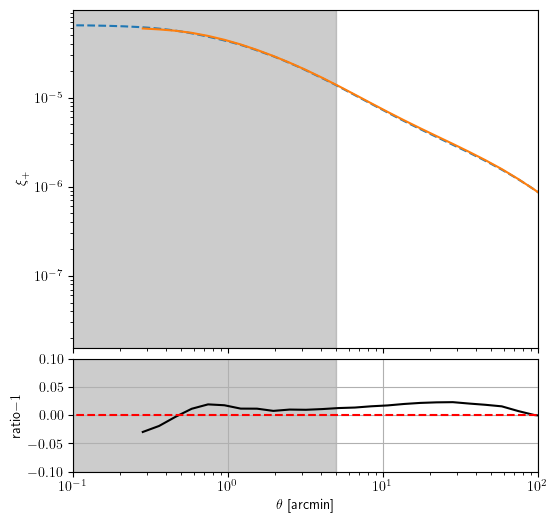

In [136]:
xi_sc = cl2xipm(l, cl_corr, N_extrap_low=0)
xi_spc= Interp1d(xi_sc[0],xi_sc[1])(meanr)
plt.close()
fig=plt.figure(figsize=(6,6))
axes=fig.subplots(2,1,gridspec_kw={'height_ratios':[3, 1],'hspace':0.05},sharex=True)
ax1=axes[0]
ax1.plot(xi_sc[0],xi_sc[1],'--',label='Model correct')
ax1.plot(meanr,xi_mock[0],'-',label='Mock')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel(r'$\xi_+$')
ax1.set_xlim(1e-1,1e3)

ax1.axvspan(1e2, 1e4, alpha=0.4,color='gray')
ax1.axvspan(1e-1, 5, alpha=0.4,color='gray')
plt.setp(ax1.get_xticklabels(), visible=False)

ax2=axes[1]
ax2.set_ylabel(r'ratio$-1$')
ax2.set_xlabel(r'$\theta$ [arcmin]')
ax2.set_xscale('log')
ax2.set_xlim(1e-1,1e2)
ax2.set_ylim(-0.1,0.1)
ax2.plot(meanr,xi_mock[0]/xi_spc-1,color='black')
ax2.plot(xi_s[0],np.zeros_like(xi_s[0]),'--',c='red')
ax2.axvspan(1e2, 1e4, alpha=0.4,color='gray')
ax2.axvspan(1e-1, 5, alpha=0.4,color='gray')
ax2.grid()
gc.collect()

21048

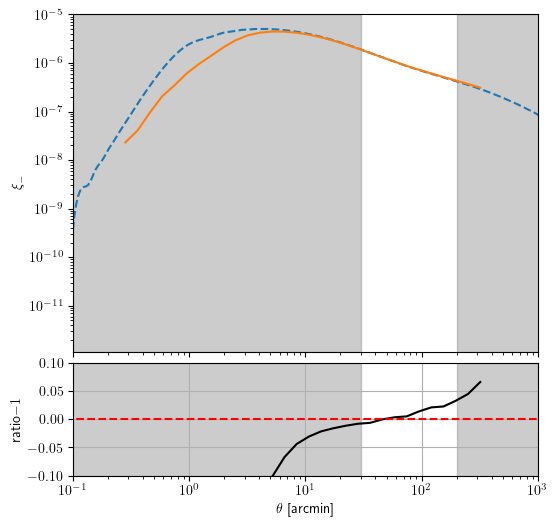

In [137]:
xi_spc= Interp1d(xi_sc[2],xi_sc[3])(meanr)
plt.close()
fig=plt.figure(figsize=(6,6))
axes=fig.subplots(2,1,gridspec_kw={'height_ratios':[3, 1],'hspace':0.05},sharex=True)
ax1=axes[0]
ax1.plot(xi_sc[2],xi_sc[3],'--',label='Model correct')
ax1.plot(meanr,xi_mock[1],'-',label='Mock')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel(r'$\xi_-$')
ax1.set_xlim(1e-1,1e3)

ax1.axvspan(2e2, 1e4, alpha=0.4,color='gray')
ax1.axvspan(1e-1, 30, alpha=0.4,color='gray')
plt.setp(ax1.get_xticklabels(), visible=False)

ax2=axes[1]
ax2.set_ylabel(r'ratio$-1$')
ax2.set_xlabel(r'$\theta$ [arcmin]')
ax2.set_xscale('log')
ax2.set_ylim(-0.1,0.1)
ax2.set_xlim(1e-1,1e3)
ax2.plot(meanr,xi_mock[1]/xi_spc-1,color='black')
ax2.plot(xi_s[0],np.zeros_like(xi_s[0]),'--',c='red')
ax2.axvspan(2e2, 1e4, alpha=0.4,color='gray')
ax2.axvspan(1e-3, 30, alpha=0.4,color='gray')
ax2.grid()
gc.collect()